References:

Logistic regression: https://towardsdatascience.com/logistic-regression-using-python-sklearn-numpy-mnist-handwriting-recognition-matplotlib-a6b31e2b166a

ROC curves: https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

Controlling the threshold in Logistic Regression in Scikit Learn: https://stackoverflow.com/questions/28716241/controlling-the-threshold-in-logistic-regression-in-scikit-learn

sklearn.metrics.precision_recall_curve: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_curve.html


# Preprocessing

In [420]:
import pickle
import pandas as pd
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, classification_report, precision_recall_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

In [421]:
with open('curation_dataset.pkl', 'rb') as f:
    data_dict = pickle.load(f)

In [422]:
# Load the data
df = pd.DataFrame.from_dict(data_dict)
# Preprocessing: replace missing values with 0s and encode stmt type as int
df = df.fillna(0).sample(frac=1)
le = LabelEncoder()
le.fit(df.stmt_type)
df.stmt_type = le.transform(df.stmt_type)
x_df = df.drop('correct', axis=1)
x = x_df.values
y = df.correct.values

In [432]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
#x_train, x_test, y_train, y_test = (x, x, y, y)

# Train Models

In [433]:
models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest Classifier': RandomForestClassifier(),
}
clf_results = {}
for clf_name, clf in models.items():
    clf.fit(x_train, y_train)
    clf_result = {}
    clf_result['y_preds'] = clf.predict(x_test)
    clf_result['y_probs'] = clf.predict_proba(x_test)
    clf_results[clf_name] = clf_result

In [434]:
sparser_ex = np.array([[0, 0, 1,0, 0, 0, 0, 0, 0, 0, 0, 0]])
models['Logistic Regression'].predict_proba(sparser_ex)
models['Random Forest Classifier'].predict_proba(sparser_ex)

array([[0.494875, 0.505125]])

# ROC Curves

In [435]:
# Compute ROC curve and ROC area for each class
roc_results = {}
for clf_name, clf_result in clf_results.items():
    fpr, tpr, thresholds = roc_curve(y_test, clf_result['y_probs'][:, 1])
    roc_auc = auc(fpr, tpr)
    roc_result = {}
    roc_result['fpr'] = fpr
    roc_result['tpr'] = tpr
    roc_result['roc_auc'] = roc_auc
    roc_results[clf_name] = roc_result

# Compute micro-average ROC curve and ROC area
#fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
#roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [436]:
with open('belief_fpr_tpr_auc.pkl', 'rb') as f:
    bel_fpr, bel_tpr, bel_roc_auc = pickle.load(f)


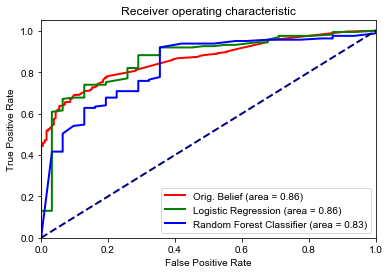

In [446]:
plt.figure()
lw = 2
colors = ['r', 'g', 'b']

# Plot ROC curve for Belief Model (REACH)
plt.plot(bel_fpr, bel_tpr, color=colors[0],
         lw=lw, label='Orig. Belief (area = %0.2f)' % bel_roc_auc)
for i, (clf_name, roc_result) in enumerate(roc_results.items()):
    fpr = roc_result['fpr']
    tpr = roc_result['tpr']
    roc_auc = roc_result['roc_auc']
    plt.plot(fpr, tpr, color=colors[i+1],
         lw=lw, label='%s (area = %0.2f)' % (clf_name, roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('bel_roc.pdf')
plt.show()


In [384]:
print(classification_report(y_test, y_preds, labels=[0, 1]))

              precision    recall  f1-score   support

           0       0.27      0.22      0.24        37
           1       0.82      0.86      0.84       155

    accuracy                           0.73       192
   macro avg       0.54      0.54      0.54       192
weighted avg       0.71      0.73      0.72       192



In [440]:
with open('belief_prec_rec_thresh_auc.pkl', 'rb') as f:
    bel_prec, bel_rec, bel_thresh, bel_pr_auc = pickle.load(f)


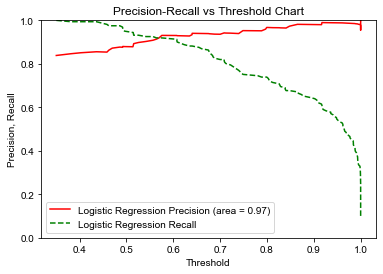

In [452]:
pr_results = {}
for clf_name, clf_result in clf_results.items():
    precision, recall, thresholds = precision_recall_curve(y_test, clf_result['y_probs'][:, 1])
    pr_auc = metrics.auc(recall, precision)
    pr_results[clf_name] = {'precision': precision, 'recall': recall,
                            'thresholds': thresholds, 'pr_auc': pr_auc}

"""
plt.figure()
plt.plot(bel_thresh, bel_prec[: -1], color=colors[0],
             linestyle='-', label="Orig. Belief Precision (area = %0.2f)" % bel_pr_auc)
plt.plot(bel_thresh, bel_rec[: -1], color=colors[0],
             linestyle='--', label="Orig. Belief Recall")
""" 

for i, (clf_name, pr_result) in list(enumerate(pr_results.items()))[0:1]:
    plt.plot(pr_result['thresholds'], pr_result['precision'][: -1], color=colors[i],
             linestyle='-', label="%s Precision (area = %0.2f)" % (clf_name, pr_result['pr_auc']))
    plt.plot(pr_result['thresholds'], pr_result['recall'][: -1], color=colors[i+1],
             linestyle='--', label="%s Recall" % clf_name)
    
plt.title("Precision-Recall vs Threshold Chart")
plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.legend(loc="lower left")
plt.ylim([0,1])
plt.savefig('prec_rec.pdf')
plt.show()

In [419]:
# Associate precision values for the statements at each threshold
# So, if a statement has probability value, check if it is above the threshold, and if so,
# assign it that precision.
list(zip(thresholds, precision))

[(0.0, 0.796875),
 (0.002, 0.7285714285714285),
 (0.0025, 0.7266187050359713),
 (0.005, 0.7246376811594203),
 (0.005161290322580645, 0.7205882352941176),
 (0.005888888888888888, 0.7185185185185186),
 (0.006296296296296296, 0.7164179104477612),
 (0.006666666666666666, 0.7142857142857143),
 (0.01, 0.7121212121212122),
 (0.015, 0.696),
 (0.0175, 0.6859504132231405),
 (0.02, 0.6833333333333333),
 (0.025, 0.6724137931034483),
 (0.025384615384615384, 0.6695652173913044),
 (0.03, 0.6666666666666666),
 (0.03139462365591398, 0.6545454545454545),
 (0.0339021223874165, 0.6513761467889908),
 (0.03833333333333334, 0.6481481481481481),
 (0.03866666666666667, 0.6542056074766355),
 (0.04, 0.6509433962264151),
 (0.0425, 0.6476190476190476),
 (0.045, 0.6442307692307693),
 (0.05, 0.6407766990291263),
 (0.05325, 0.63),
 (0.056666666666666664, 0.6262626262626263),
 (0.06, 0.6326530612244898),
 (0.06416666666666666, 0.6210526315789474),
 (0.0725, 0.6170212765957447),
 (0.07666666666666667, 0.612903225806451

[[  1  35]
 [  4 152]]


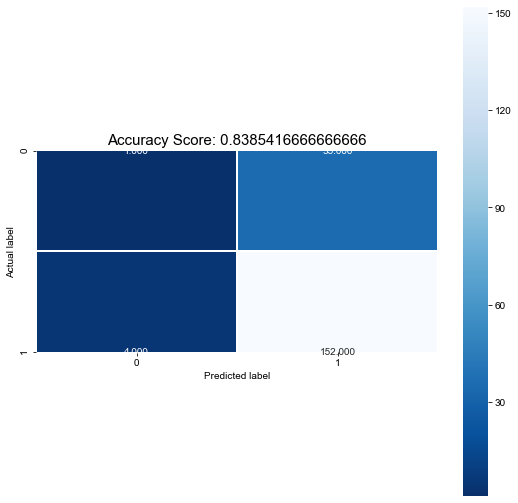

In [271]:
cm = metrics.confusion_matrix(y_test, predictions)
print(cm)
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);

# Logistic Regression

In [442]:
logisticRegr.coef_

array([[0.87739369, 0.15692754, 0.06144103, 0.0872427 , 0.61945672,
        0.89382797, 0.65239006, 0.21056681, 0.89253788, 0.32519975,
        1.03234249, 0.03817995]])

In [443]:
sorted(list(zip(x_df.columns, logisticRegr.coef_[0])), key=lambda x: x[1], reverse=True)

[('signor', 1.0323424918435298),
 ('trips', 0.8938279697624802),
 ('biopax', 0.8925378793174021),
 ('medscan', 0.8773936874665725),
 ('hprd', 0.6523900637196467),
 ('rlimsp', 0.6194567179736861),
 ('bel', 0.32519974507877825),
 ('isi', 0.2105668132903066),
 ('reach', 0.15692754349405286),
 ('stmt_type', 0.08724269900528582),
 ('sparser', 0.06144103067503523),
 ('trrust', 0.038179952170045044)]